The shape files for the UK postcode boundaries is provided by http://www.opendoorlogistics.com

In [34]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

uk_shape_file = "data/UK-postcode-boundaries-Jan-2015/Districts.shp"
uk = gpd.read_file(uk_shape_file)
uk = uk.to_crs({'init': 'epsg:3395'})
uk['Postcode Area'] = (uk['name'].str.extract('([A-Z]+)', expand=True))

In [18]:
training_file = "data/MOT_result_2016_training.csv"

mot_results = pd.read_csv(training_file, parse_dates=['test_date', 'first_use_date'])

# Count PRS (Pass with minor fix with 1 hour) as a Pass
replace_dict = {'test_result':{'PRS':'P'}, 'fuel_type':{'EL':'G', 'FC':'G', 'HY':'G'}}
mot_results = mot_results.replace(replace_dict)

mot_results['age'] = (mot_results['test_date'] - mot_results['first_use_date']) / datetime.timedelta(days=365)


In [53]:
def chloropleth(query, column, title):
    mot_totals  = mot_results.groupby(['postcode_area', column])[['test_id']].count()
    mot_rates = mot_totals.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    mot_rates.rename(columns={'test_id': 'rate'}, inplace=True)
    mot_rates = mot_rates.reset_index()
    mot_rates = mot_rates.query(query)
    uk_mot = uk.merge(mot_rates, left_on='Postcode Area', right_on='postcode_area', how='left')
    uk_mot_zero = uk_mot[uk_mot['rate'].isnull()]
    uk_mot = uk_mot[uk_mot['rate'].notnull()]
    
    
    uk_plot=uk_mot.plot(figsize=(10,15), column='rate', scheme='equal_interval', k=10, cmap='viridis',
                        legend=False, linewidth=0.1, edgecolor='grey')
    
    uk_mot_zero.plot(ax=uk_plot, linewidth=0.1, edgecolor='grey', color='white')
    
    plt.axis('off')
    plt.title(title, fontdict={'fontsize':16})

    max_value = uk_mot['rate'].max()
    min_value = uk_mot['rate'].min()

    # Add axes for colorbar
    cbaxes = uk_plot.figure.add_axes([0.8, 0.65, 0.03, 0.15]) 
    # Dummy data for (fake) contourplot

    # Range required for colorbar
    levels = np.arange(min_value,max_value+1.0,1.0)
    zeros = np.zeros(levels.shape)
    # Dummy plot used to create colorbar
    CS3 = plt.scatter(x=zeros, y=zeros, s=zeros, c=levels, cmap='viridis')
    cbar = plt.colorbar(CS3, cax=cbaxes)
    
    labels = cbar.ax.get_yticklabels()
    format_labels = [l.get_text()+'%' for l in labels]
    cbar.ax.set_yticklabels(format_labels)

    plt.show()

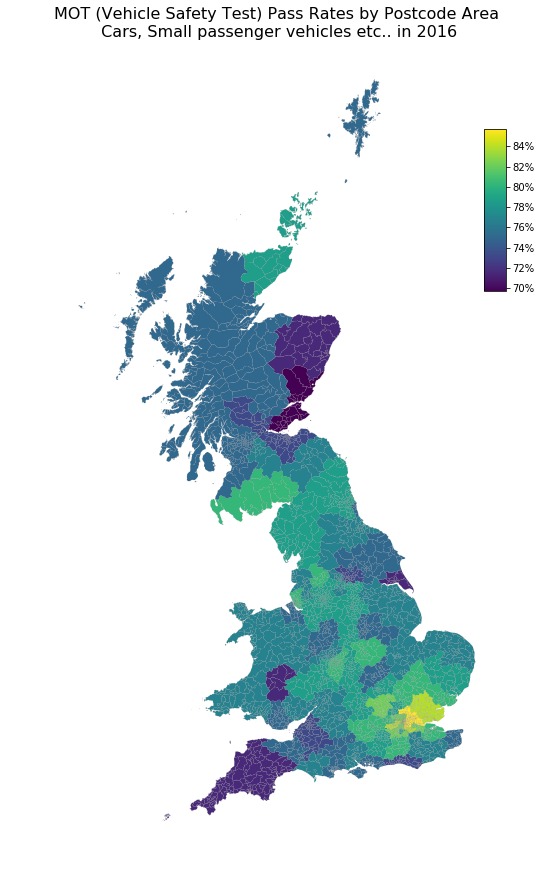

In [54]:
chloropleth(query='test_result=="P"',
            column='test_result',
            title='MOT (Vehicle Safety Test) Pass Rates by Postcode Area\n Cars, Small passenger vehicles etc.. in 2016'
           )

In [19]:
mot_results.head()

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,age
0,635544879,1123718405,2016-01-04,4,NT,F,22263.0,BN,SUZUKI,SWIFT SZ3 DDIS,BLUE,DI,1248.0,2013-09-26,2.273973
1,1135632171,259476332,2016-01-04,4,NT,F,72386.0,WS,PEUGEOT,3008,RED,DI,1560.0,2010-03-02,5.846575
2,1821645967,1196670034,2016-01-03,4,NT,P,58479.0,ME,NISSAN,QASHQAI,BLUE,DI,1461.0,2010-06-28,5.520548
3,727411847,257196698,2016-01-04,4,NT,F,54344.0,BA,VAUXHALL,CORSA,SILVER,PE,1364.0,2007-05-16,8.643836
4,1061185063,1453769504,2016-01-04,4,NT,P,56529.0,PL,MG,ZR,SILVER,PE,1396.0,2005-04-18,10.720548


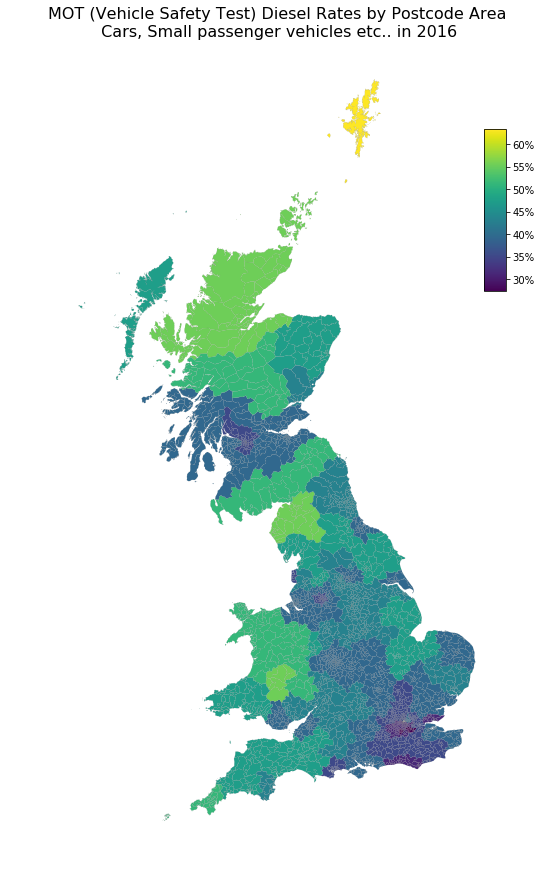

In [55]:
chloropleth(query='fuel_type=="DI"',
            column='fuel_type',
            title='MOT (Vehicle Safety Test) Diesel Rates by Postcode Area\n Cars, Small passenger vehicles etc.. in 2016'
           )

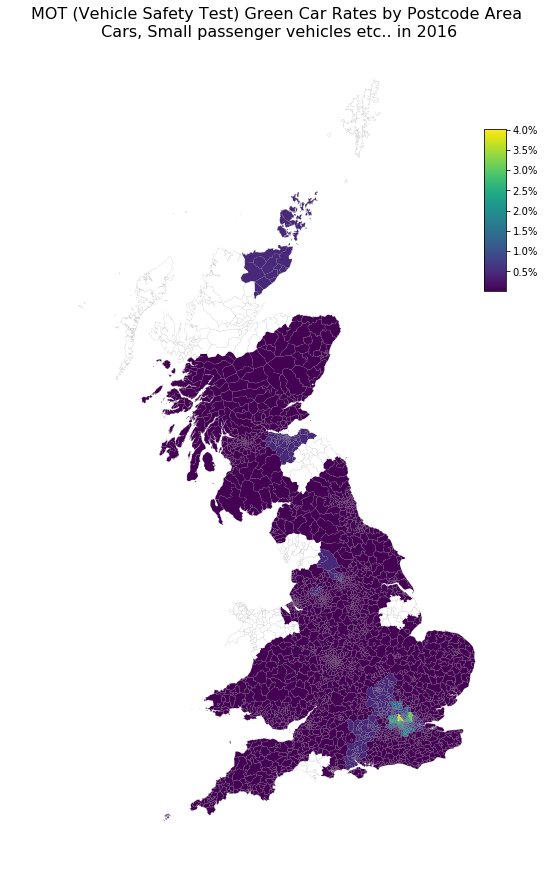

In [56]:
chloropleth(query='fuel_type=="G"',
            column='fuel_type',
            title='MOT (Vehicle Safety Test) Green Car Rates by Postcode Area\n Cars, Small passenger vehicles etc.. in 2016'
           )

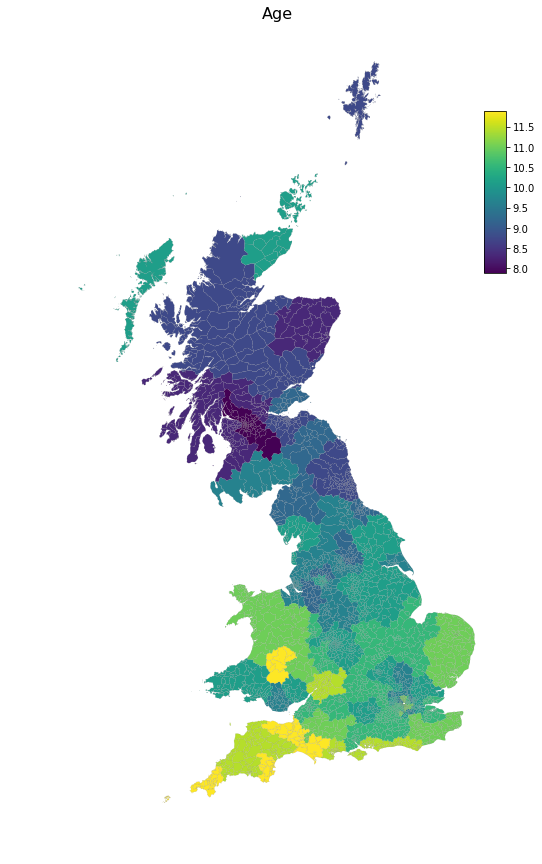

In [52]:
mot_age  = mot_results.groupby('postcode_area')[['age']].mean()
mot_age = mot_age.reset_index()
uk_mot = uk.merge(mot_age, left_on='Postcode Area', right_on='postcode_area', how='left')
uk_mot = uk_mot[uk_mot['age'].notnull()]

uk_plot=uk_mot.plot(figsize=(10,15), column='age', scheme='equal_interval', k=10, cmap='viridis',
                    legend=False, linewidth=0.1, edgecolor='grey')


plt.axis('off')
plt.title('Age', fontdict={'fontsize':16})


max_value = uk_mot['age'].max()
min_value = uk_mot['age'].min()

# Add axes for colorbar
cbaxes = uk_plot.figure.add_axes([0.8, 0.65, 0.03, 0.15]) 
# Dummy data for (fake) contourplot

# Range required for colorbar
levels = np.arange(min_value,max_value+1.0,1.0)
zeros = np.zeros(levels.shape)
# Dummy plot used to create colorbar
CS3 = plt.scatter(x=zeros, y=zeros, s=zeros, c=levels, cmap='viridis')
cbar = plt.colorbar(CS3, cax=cbaxes) 

plt.show()

In [46]:
uk_mot['age'].max()


11.462250972433626